In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from pdf2image import convert_from_path

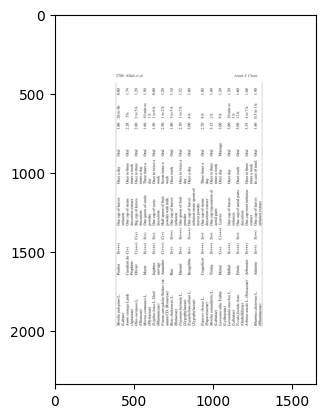

In [14]:
pdf_file = "data/biblio-a1-nord-allali.pdf"
images = convert_from_path(pdf_file)
plt.imshow(images[5])


In [15]:
doc = images[5]

In [12]:
def correct_angle(image, verbose=False):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
    coords = np.column_stack(np.where(thresh > 0))
    angle = cv2.minAreaRect(coords)[-1]
    angle = -(90 + angle) if angle < -45 else -angle

    h, w = image.shape[:2]
    (c_x, c_y) = (w // 2, h // 2)
    matrix = cv2.getRotationMatrix2D((c_x, c_y), angle, 1.0)

    cos = np.abs(matrix[0, 0])
    sin = np.abs(matrix[0, 1])

    n_w = int((h * sin) + (w * cos))
    n_h = int((h * cos) + (w * sin))

    matrix[0, 2] += (n_w / 2) - c_x
    matrix[1, 2] += (n_h / 2) - c_y

    return cv2.warpAffine(image, matrix, (n_w, n_h), borderValue=(255, 255, 255))

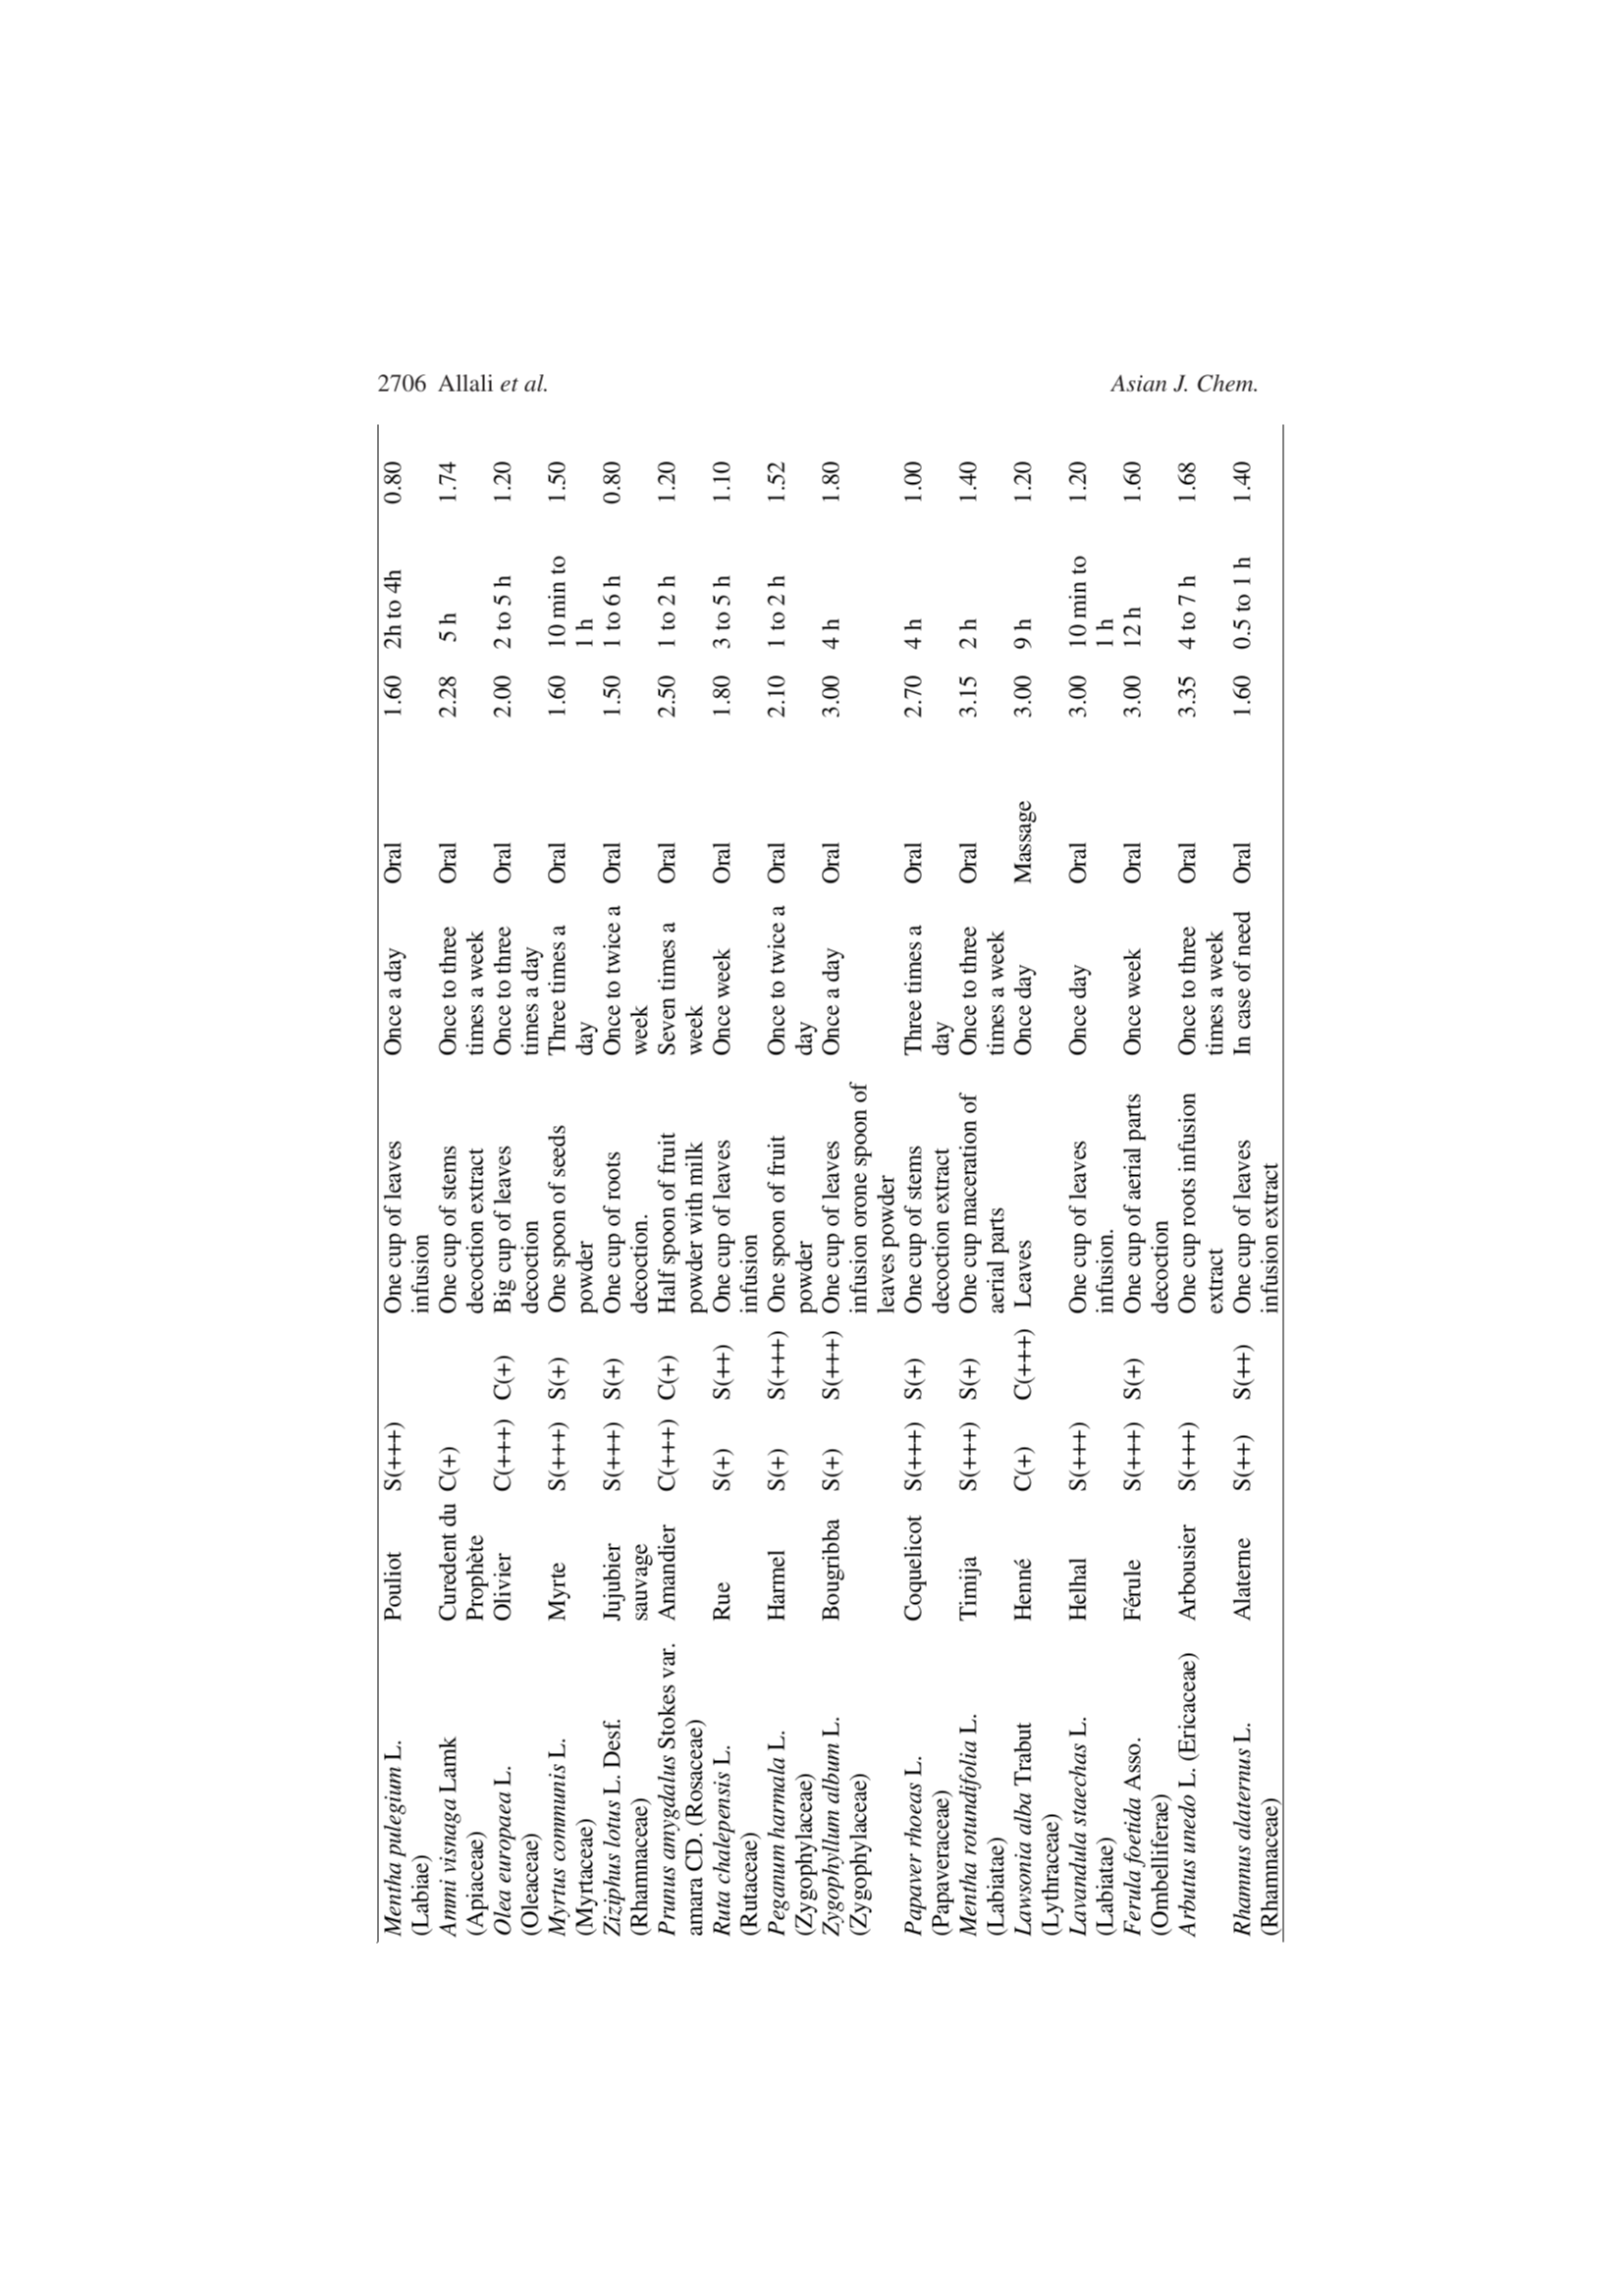

In [16]:
doc_200 = np.array(doc)
corrected_image = correct_angle(doc_200, True)
Image.fromarray(corrected_image)

In [17]:
def detect_flip(image, verbose=False):
    mask = np.zeros(image.shape, dtype=np.uint8)
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    blur = cv2.GaussianBlur(gray, (3,3), 0)
    adaptive = cv2.adaptiveThreshold(
            blur,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV,15,4
    )

    cnts = cv2.findContours(adaptive, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]

    for c in cnts:
        area = cv2.contourArea(c)
        if area < 45000 and area > 20:
            cv2.drawContours(mask, [c], -1, (255,255,255), -1)

    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    h, w = mask.shape

    if verbose:
        fig, ax = plt.subplots(1,3, figsize=(20, 20))
        ax[0].imshow(image)
        ax[0].set_title('Original', fontsize=12)
        ax[0].axis('off')
        ax[1].imshow(adaptive, cmap='gray')
        ax[1].set_title('Thresholded', fontsize=12)
        ax[1].axis('off')
        ax[2].imshow(mask, cmap='gray')
        ax[2].set_title('Mask', fontsize=12)
        ax[2].axis('off')
        plt.show()


    left = mask[0:h, 0:0+w//2]
    right = mask[0:h, w//2:]
    left_pixels = cv2.countNonZero(left)
    right_pixels = cv2.countNonZero(right)
    return 0 if left_pixels >= right_pixels else 180

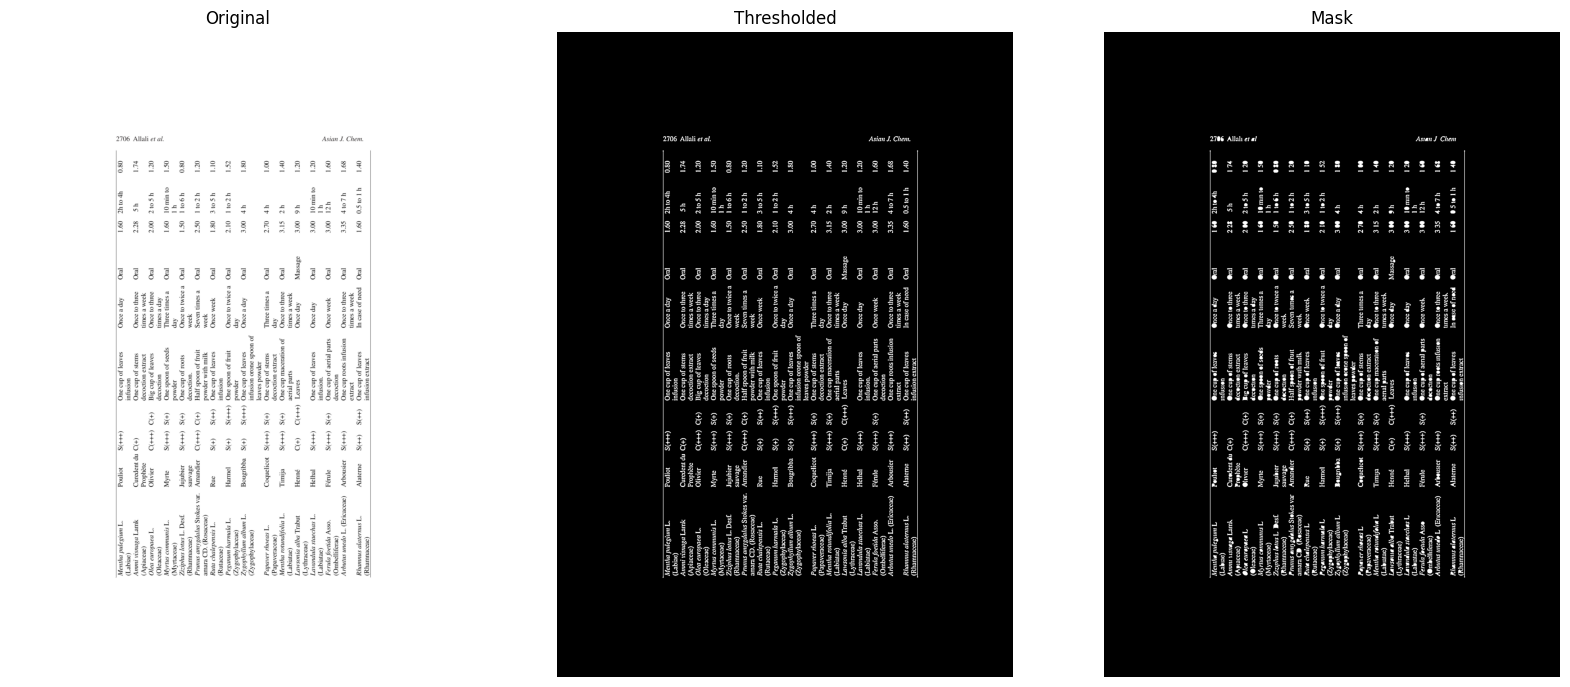

0


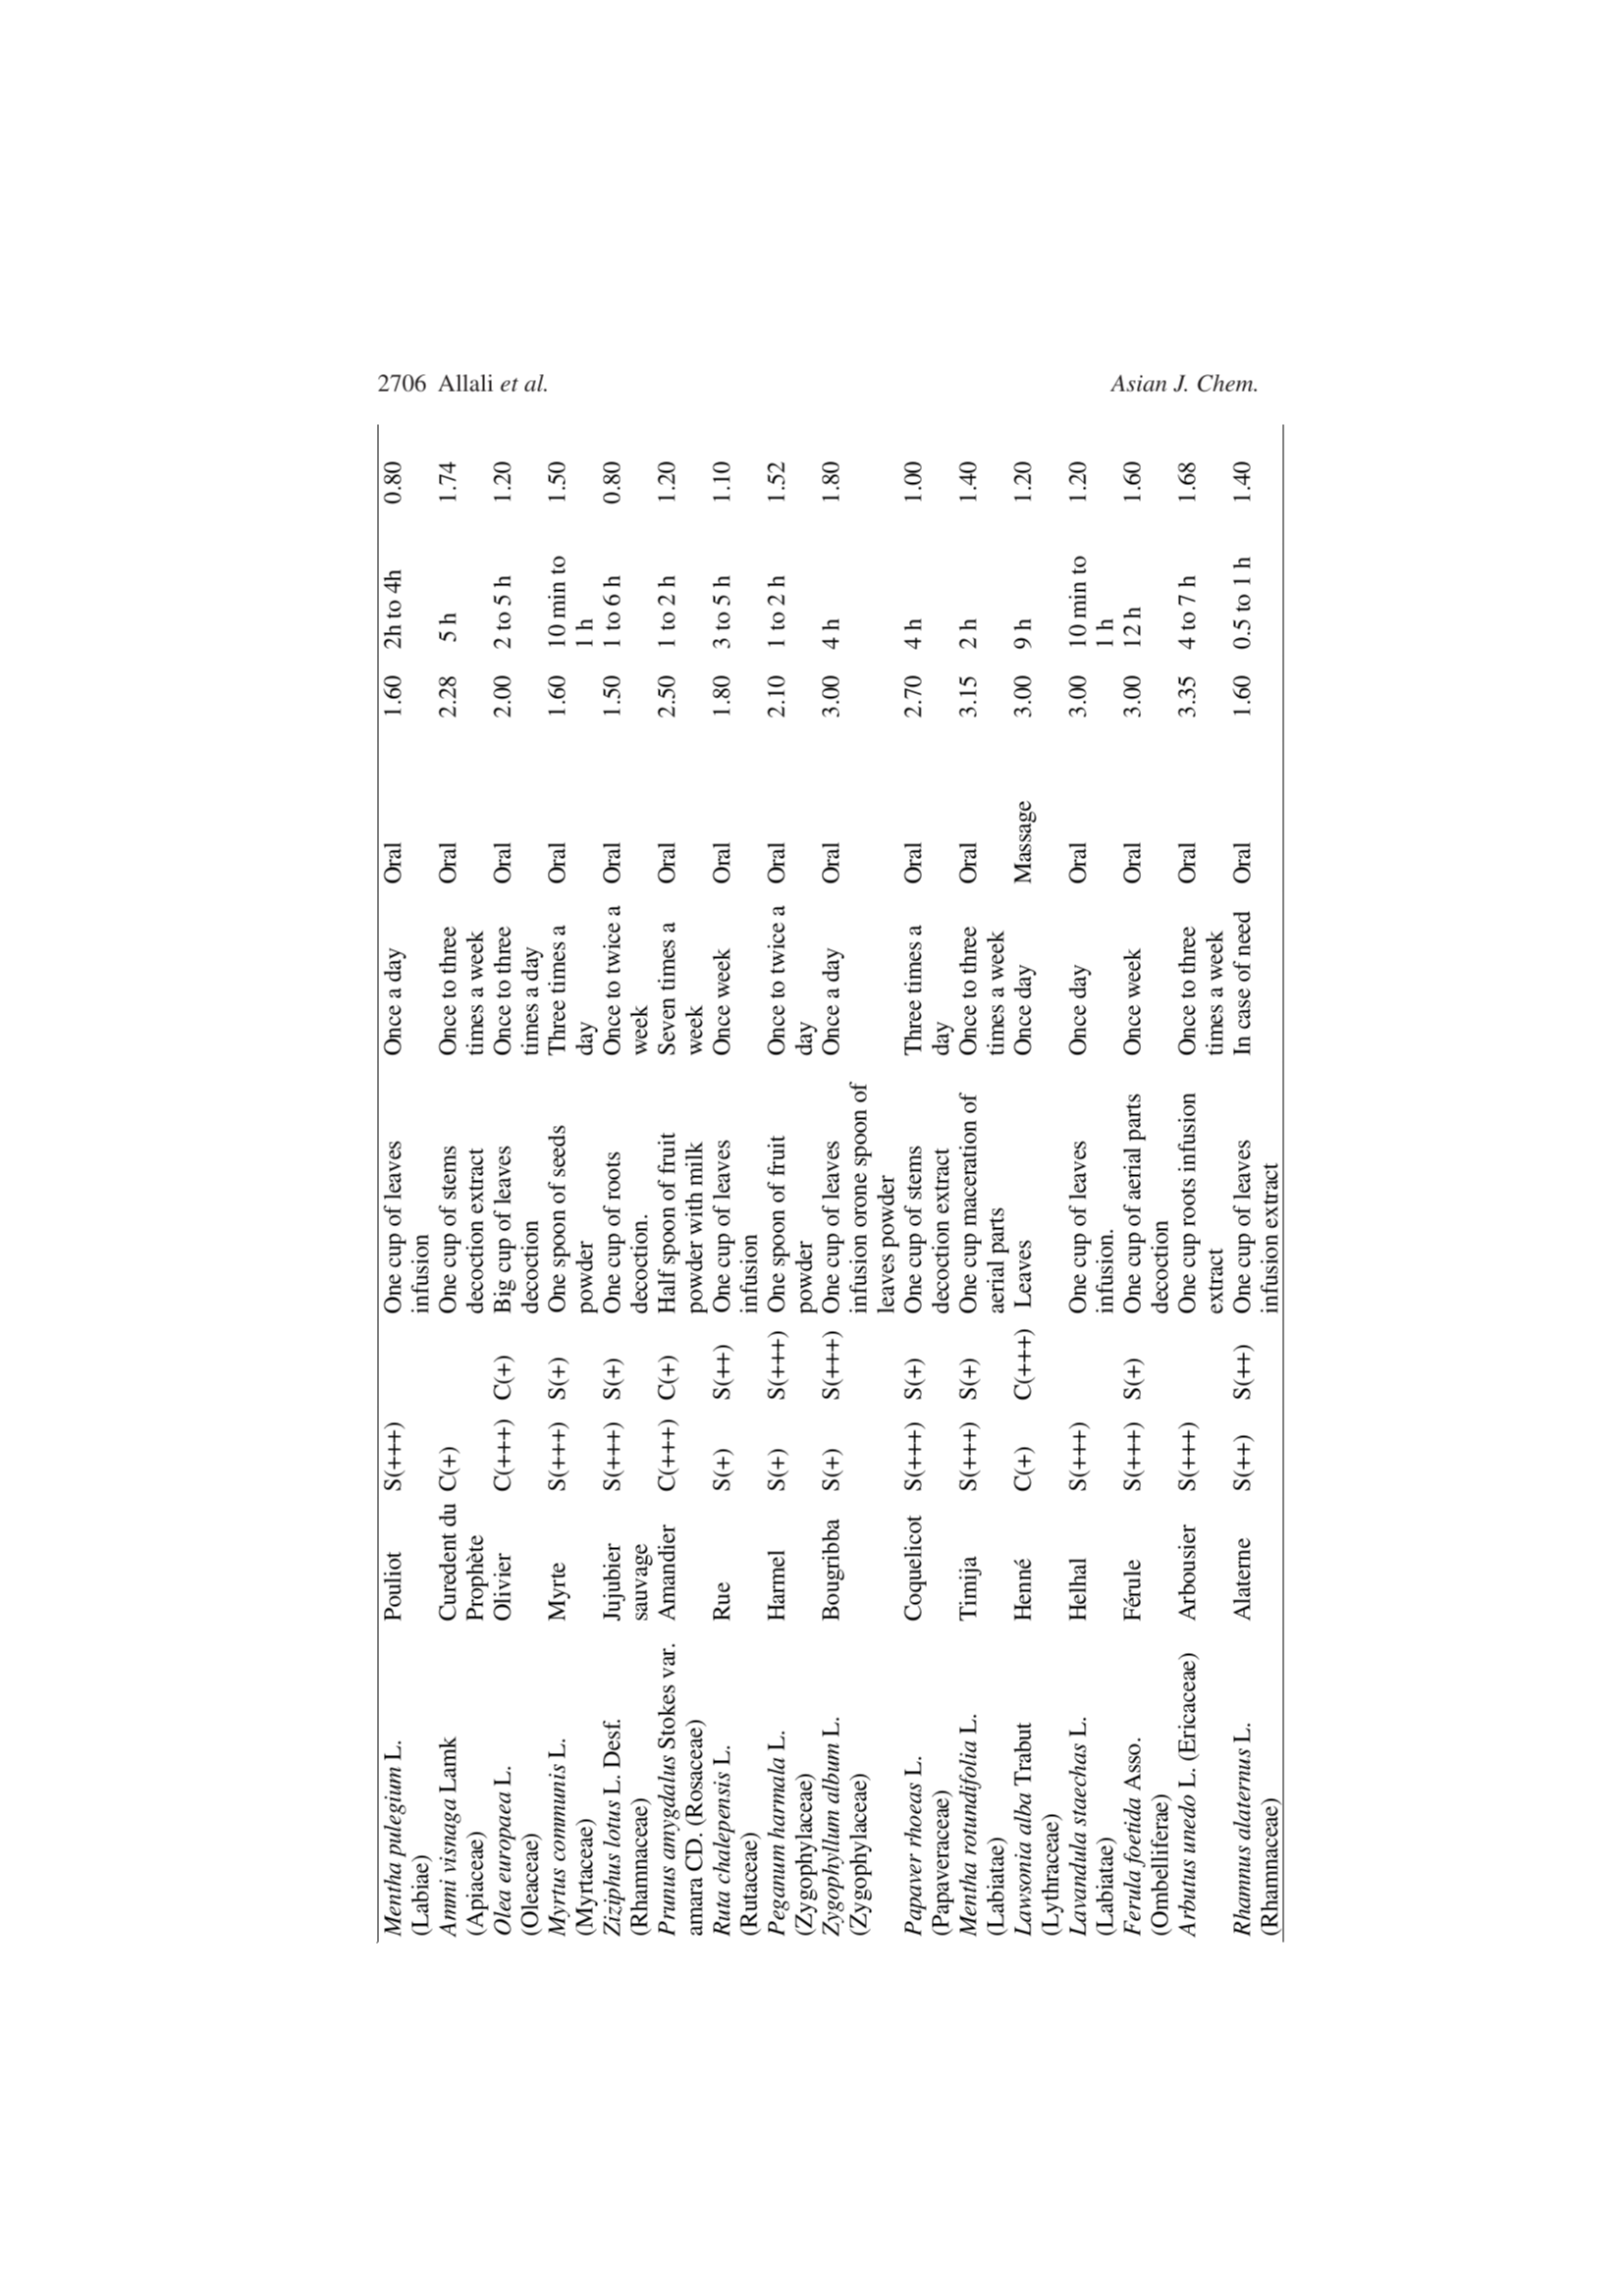

In [18]:
doc_180 = corrected_image
angle = detect_flip(doc_180, True)
print(angle)
corrected_image = Image.fromarray(corrected_image).rotate(angle)
corrected_image

In [19]:
#  Download the PDF file
import os
import requests

def download_pdf(url, output_dir='data'):
    os.makedirs(output_dir, exist_ok=True)
    response = requests.get(url)
    if response.status_code == 200:
        with open(os.path.join(output_dir, url.split('/')[-1]), "wb") as file:
            file.write(response.content)
        return os.path.join(output_dir, url.split('/')[-1])
    else:
        raise Exception(f"Failed to download {url}: Status code {response.status_code}")

In [20]:
download_pdf("https://www.wahooas.org/web-ooas/sites/default/files/publications/2318/pharmacopee-de-lafrique-de-louest-french.pdf")

ConnectTimeout: HTTPSConnectionPool(host='www.wahooas.org', port=443): Max retries exceeded with url: /web-ooas/sites/default/files/publications/2318/pharmacopee-de-lafrique-de-louest-french.pdf (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x1232ad550>, 'Connection to www.wahooas.org timed out. (connect timeout=None)'))

In [32]:
from mistralai import Mistral
import os
from pathlib import Path
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

True

In [33]:
api_key = os.getenv("MISTRAL_API_KEY")
client = Mistral(api_key=api_key)

In [34]:
pdf_files = list(Path("data_correct").glob("*.pdf"))

In [35]:
pdf_file = Path(pdf_files[0])
assert pdf_file.is_file()

In [36]:
pdf_file

PosixPath('data_correct/biblio-vt-24-tabuti.pdf')

In [37]:

from mistralai import DocumentURLChunk, ImageURLChunk, TextChunk
import json

uploaded_file = client.files.upload(
        file={
                "file_name": pdf_file.stem,
                "content": pdf_file.read_bytes(),
        },
        purpose="ocr",
)

signed_url = client.files.get_signed_url(file_id=uploaded_file.id, expiry=1)

pdf_response = client.ocr.process(document=DocumentURLChunk(document_url=signed_url.url), model="mistral-ocr-latest", include_image_base64=True)

response_dict = json.loads(pdf_response.model_dump_json())
json_string = json.dumps(response_dict, indent=4)
print(json_string)

{
    "pages": [
        {
            "index": 0,
            "markdown": "# Ethnoveterinary medicines for cattle (Bos indicus) in Bulamogi county, Uganda: plant species and mode of use \n\nJohn R. S. Tabuti, Shivcharn S. Dhillion ${ }^{\\text {b, c }}$ and Kaare A. Lye\n\n\n#### Abstract\n\nLivestock rearing is a key economic activity of Uganda and contributes 7.3\\% of the Gross Domestic Product ([World Bank, 1993, NEMA, 1998 and MAAIF and MFPED, 2000]). Of all the livestock that are raised in Uganda, cattle are the most important in terms of economic value ([World Bank, 1993]). The size of the cattle herd in Uganda is estimated to be growing ( [NEMA, 1998]), but diseases seriously hamper production from cattle. Epidemic diseases such as rinderpest, and endemic ones like foot and mouth and tick borne diseases normally afflict cattle in Uganda. The clinical service of the public veterinary service is believed to be inefficient and seen to have minimal effect on animal health ([World 

/var/folders/kx/kwzs_5p933b6h50__7gh_t7w0000gn/T/ipykernel_34208/3472710983.py:16: PydanticDeprecatedSince20: The `json` method is deprecated; use `model_dump_json` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  response_dict = json.loads(pdf_response.json())


In [31]:
print(api_key)

None
